In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from glob import glob
from functools import wraps
import json
from itertools import tee
import re

In [3]:
from matplotlib import pyplot as plt
from joblib import delayed, Parallel
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
# Change the default settings for plotting
plt.rcParams['figure.dpi'] = 100

# Do some monkey patching to fix pandas/#15296
if not hasattr(pd.read_msgpack, 'read_msgpack'):
    @wraps(pd.read_msgpack)
    def read_msgpack(*args, **kwargs):
        df = read_msgpack.read_msgpack(*args, **kwargs)
        df.columns = [c.decode('utf-8') for c in df.columns]
        return df

    read_msgpack.read_msgpack = pd.read_msgpack
    pd.read_msgpack = read_msgpack
# Helpful function
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [5]:
scenarios = ['tip_x=0um_y=+5000um', 'Original_DB', 'tip_x=0um_y=-5000um']
# for scenario in glob('output/scenarios/*/particles.msg'):
#     scenarios.append(scenario[len('output/scenarios/'):-len('/particles.msg')])

clusters, tracks, residuals, particles = [], [], [], []
for scenario in scenarios:
    df = pd.read_msgpack(f'output/scenarios/{scenario}/clusters.msg')
    df['scenario'] = pd.Categorical([scenario]*len(df), categories=scenarios)
    clusters.append(df)

    df = pd.read_msgpack(f'output/scenarios/{scenario}/tracks.msg')
    df['scenario'] = pd.Categorical([scenario]*len(df), categories=scenarios)
    tracks.append(df)

    df = pd.read_msgpack(f'output/scenarios/{scenario}/residuals.msg')
    df['scenario'] = pd.Categorical([scenario]*len(df), categories=scenarios)
    residuals.append(df)

    df = pd.read_msgpack(f'output/scenarios/{scenario}/particles.msg')
    df['scenario'] = pd.Categorical([scenario]*len(df), categories=scenarios)
    particles.append(df)

clusters = pd.concat(clusters)
tracks = pd.concat(tracks)
residuals = pd.concat(residuals)
particles = pd.concat(particles)

# residuals.eval('residual = sqrt(residual_x**2 + residual_y**2 + residual_z**2)', inplace=True)
# residuals.eval('true_residual = sqrt(true_residual_x**2 + true_residual_y**2 + true_residual_z**2)', inplace=True)
residuals['station'] = np.floor_divide(residuals.module, 2)

tracks.track_type = list(map(lambda s: s.decode('utf-8'), tracks.track_type))
tracks.track_type = tracks.track_type.astype('category')

tracks.eval('p = sqrt(px**2 + py**2 + pz**2)', inplace=True)
tracks.eval('pt = sqrt(px**2 + py**2)', inplace=True)
tracks.eval('true_p = sqrt(true_px**2 + true_py**2 + true_pz**2)', inplace=True)
tracks.eval('true_pt = sqrt(true_px**2 + true_py**2)', inplace=True)

particles.eval('fd = sqrt('
    '(vertex_x - true_dst_vertex_x)**2 + '
    '(vertex_y - true_dst_vertex_y)**2 + '
    '(vertex_z - true_dst_vertex_z)**2'
')', inplace=True)

particles.eval('true_fd = sqrt('
    '(true_d0_vertex_x - true_dst_vertex_x)**2 + '
    '(true_d0_vertex_y - true_dst_vertex_y)**2 + '
    '(true_d0_vertex_z - true_dst_vertex_z)**2'
')', inplace=True)
D0_mass = 1864.84
speed_of_light = 299792458
particles.eval('D0_p = sqrt(D0_p_x**2 + D0_p_y**2 + D0_p_z**2)', inplace=True)
particles.eval(f'D0_gamma = 1/sqrt(1 + D0_p**2/{D0_mass**2})', inplace=True)

In [6]:
sigma = {
    0.5: 0.382924922548026,
    1: 0.682689492137086,
    2: 0.954499736103642,
    3: 0.997300203936740
}
bins = np.linspace(-0.2, 0.2, 100)
sns.set_palette(sns.color_palette('colorblind', len(scenarios)))
sns.set_style('whitegrid')

In [7]:
particles.scenario.cat.categories

Index(['tip_x=0um_y=+5000um', 'Original_DB', 'tip_x=0um_y=-5000um'], dtype='object')

## $x/y/z$ residuals

Here the residual is plotted between:
 - The cluster position in the true geometry
 - The point of closest approach for the track reconstuced in the misaligned geometry

As you might expect this only (appreciably) affects the residual in $x$ for rotations around $y$

(-0.20000000000000001, 0.20000000000000001)

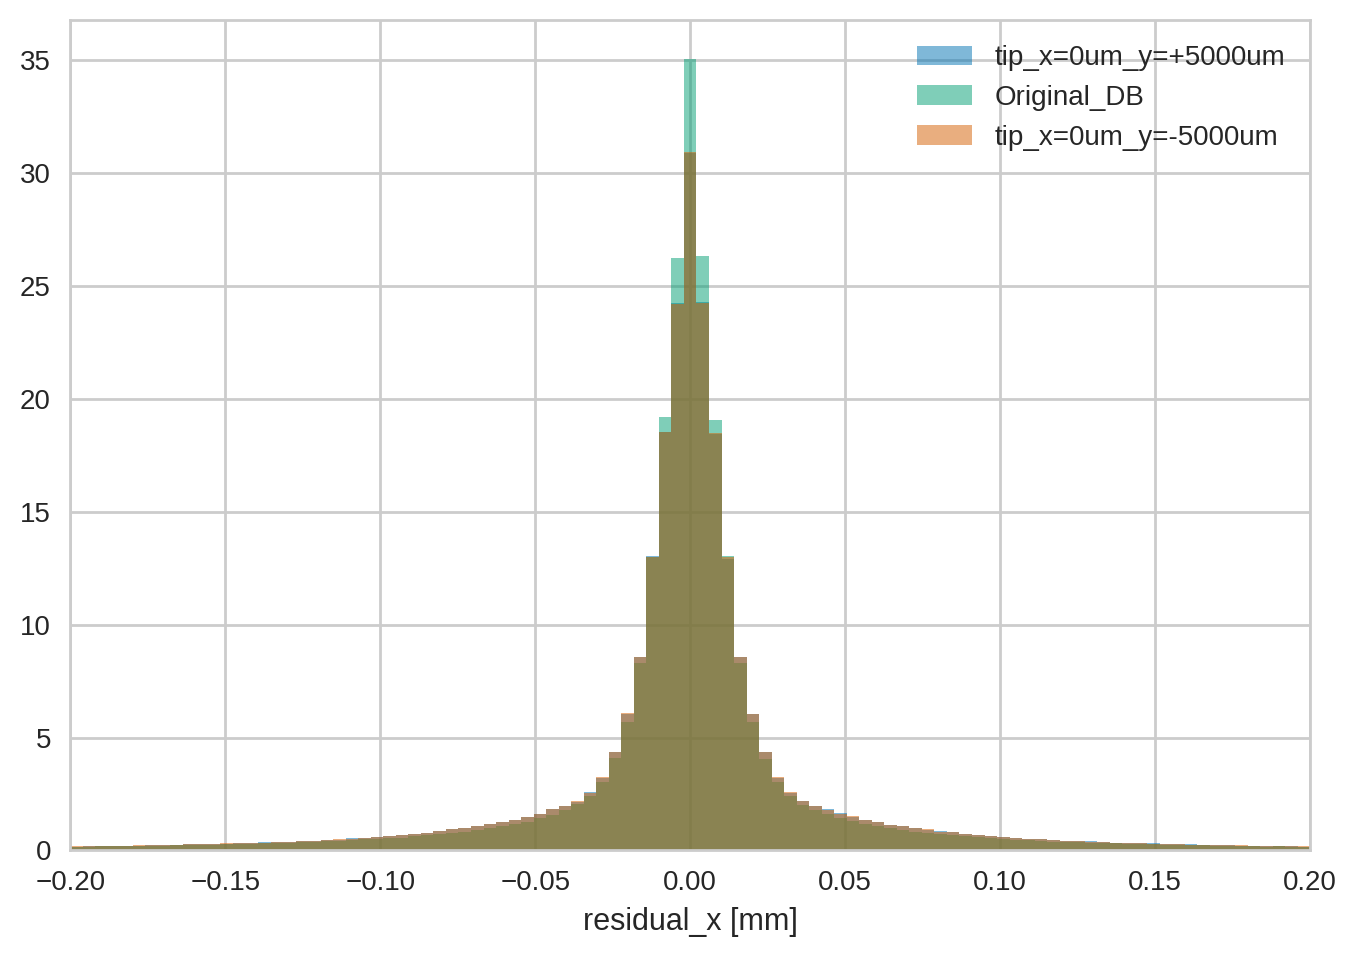

In [8]:
for scenario in scenarios:
    residuals.query(f'scenario == "{scenario}"').residual_x.hist(bins=bins, normed=True, alpha=0.5, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_x [mm]')
plt.xlim((bins[0], bins[-1]))

(-0.20000000000000001, 0.20000000000000001)

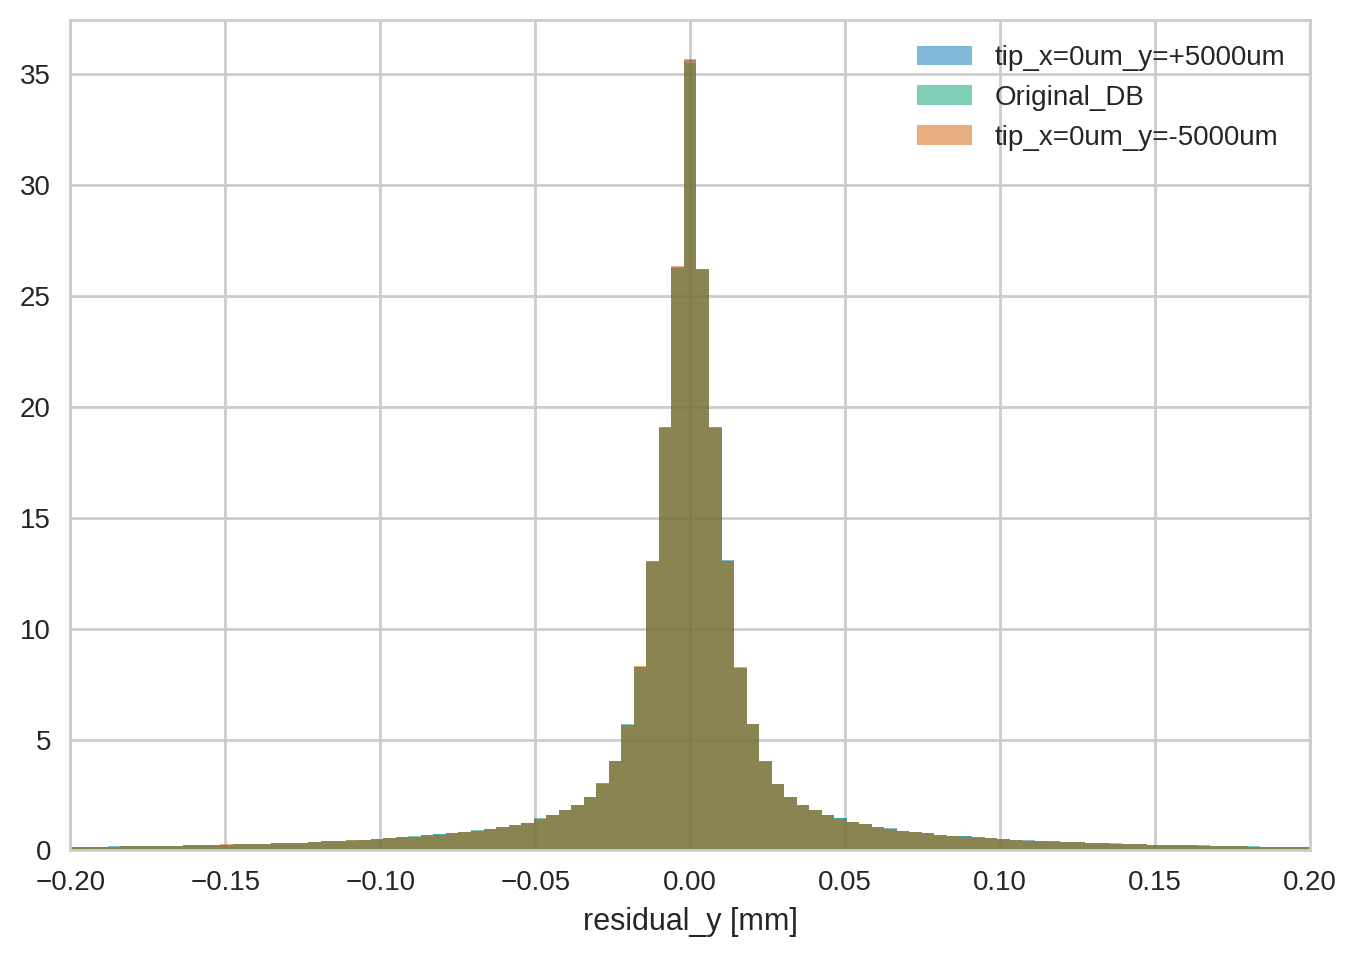

In [9]:
for scenario in scenarios:
    residuals.query(f'scenario == "{scenario}"').residual_y.hist(bins=bins, normed=True, alpha=0.5, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_y [mm]')
plt.xlim((bins[0], bins[-1]))

(-0.20000000000000001, 0.20000000000000001)

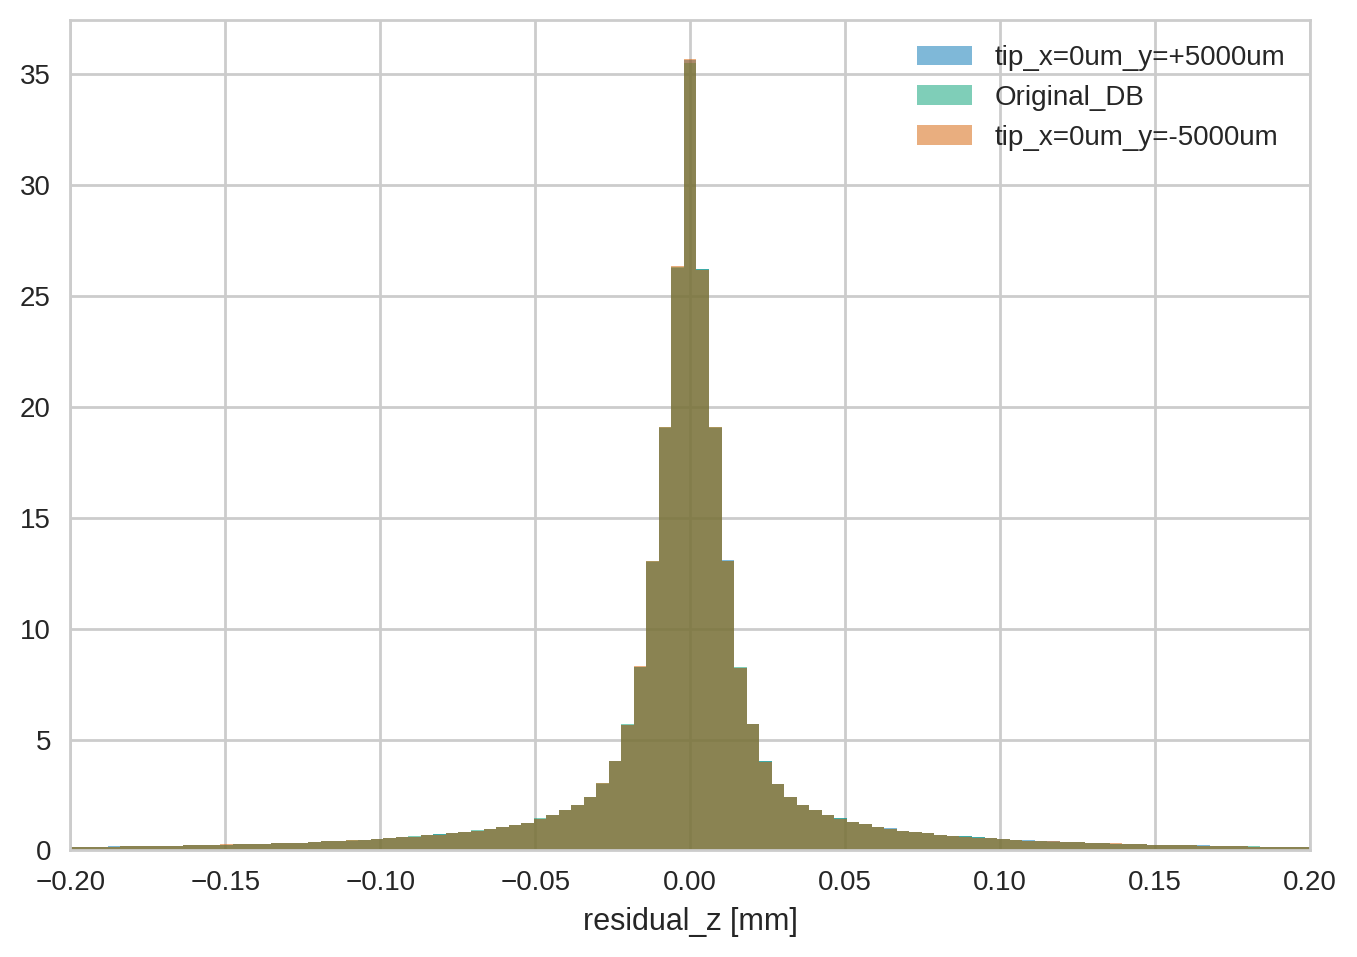

In [10]:
for scenario in scenarios:
    residuals.query(f'scenario == "{scenario}"').residual_y.hist(bins=bins, normed=True, alpha=0.5, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_z [mm]')
plt.xlim((bins[0], bins[-1]))

## $x/y/z$ residuals as a function of VP station

Here I plot the $x/y/z$ residuals (above) as a function of VP station. The coutour lines corrosponding to the median, $\pm1\sigma$ and $\pm2\sigma$ are shown, where the values are obtained by taking the percentiles of the residual distribution.

I also plot the true residual, which is the residual between the true cluster location (using nominal geometry) and the track.

In [11]:
station_positions = {
    0: -281.25, 1: -256.25, 2: -231.25, 3: -206.25, 4: -131.25, 5: -56.25, 6: -31.25,
    7: -6.25, 8: 18.75, 9: 43.75, 10: 68.75, 11: 93.75, 12: 118.75, 13: 143.75,
    14: 168.75, 15: 193.75, 16: 218.75, 17: 243.75, 18: 268.75, 19: 318.75,
    20: 393.75, 21: 493.75, 22: 593.75, 23: 643.75, 24: 693.75, 25: 743.75
}

In [12]:
def plot_residual(var, vs_station=False):
    for scenario, colour in zip(scenarios, sns.color_palette(n_colors=len(scenarios))):
        data = residuals.query(f'scenario == "{scenario}"')
        stations = sorted(data.station.unique())
        ys = []
        for station in stations:
            if scenario == 'Original_DB' and var.startswith('true_residual'):
                residual = data.query(f'station == {station}')[var[len('true_'):]]
            else:
                residual = data.query(f'station == {station}')[var]
            ys.append([
                residual.quantile(0.5+sigma[2]/2),
                residual.quantile(0.5+sigma[1]/2),
                residual.median(),
                residual.quantile(0.5-sigma[1]/2),
                residual.quantile(0.5-sigma[2]/2)
            ])
        if vs_station:
            xs = stations
        else:
            xs = [station_positions[x] for x in stations]
        for y, alpha in zip(zip(*ys), [0.25, 0.75, 1, 0.75, 0.25]): 
            plt.plot(xs, y, c=colour, alpha=alpha, label=(scenario if alpha == 1 else None))

    plt.legend(loc='best')
    if vs_station:
        plt.xlim((0, 25))
    else:
        plt.xlim((station_positions[0], station_positions[25]))
    plt.xlabel('VP station')
    plt.ylabel(f'{var} [mm]')

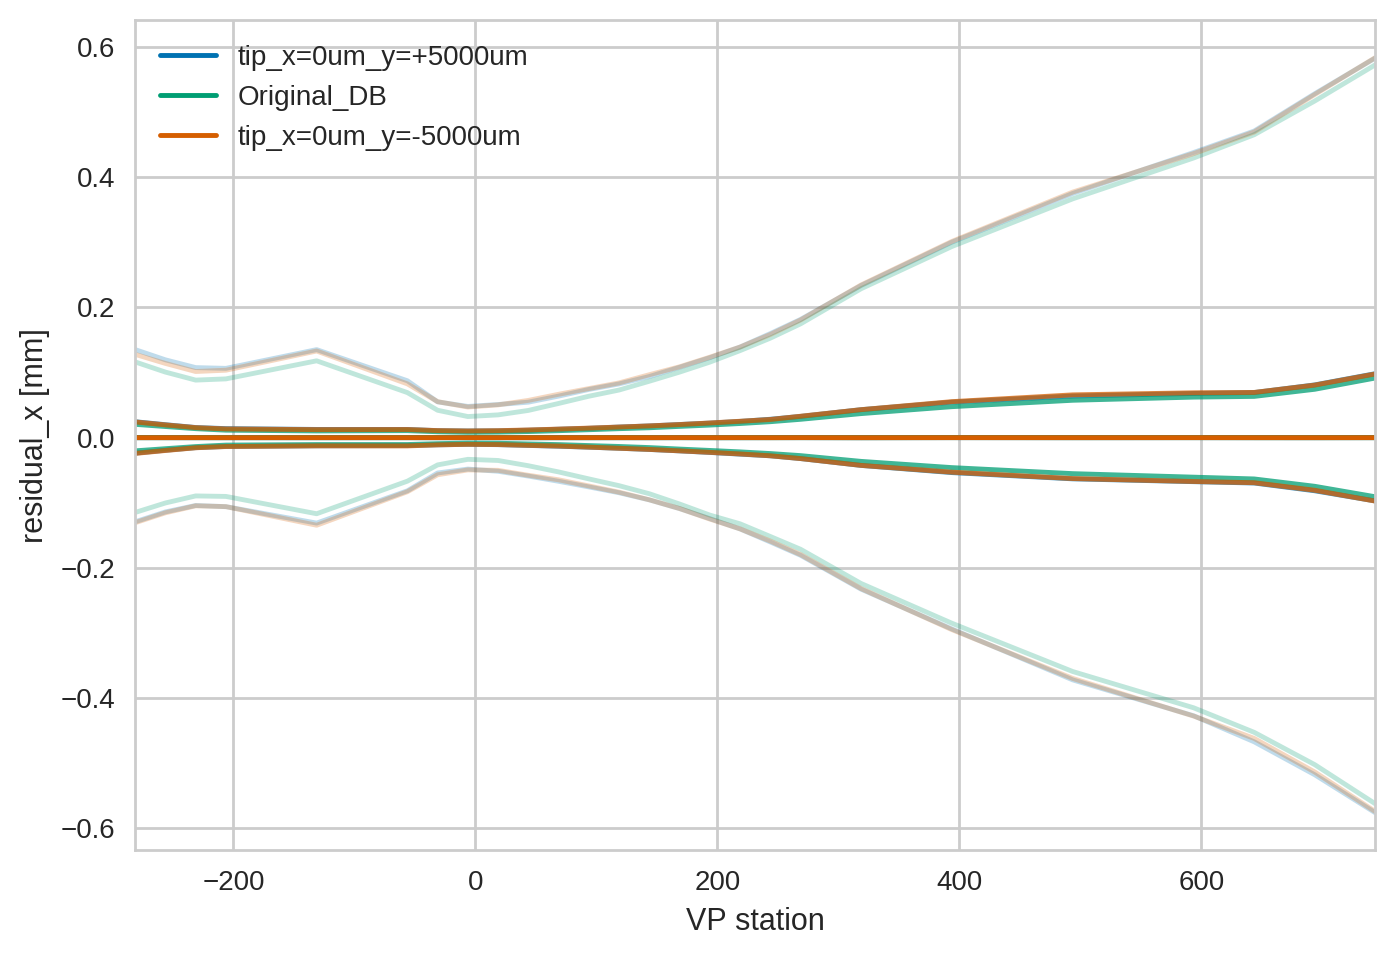

In [13]:
plot_residual('residual_x')

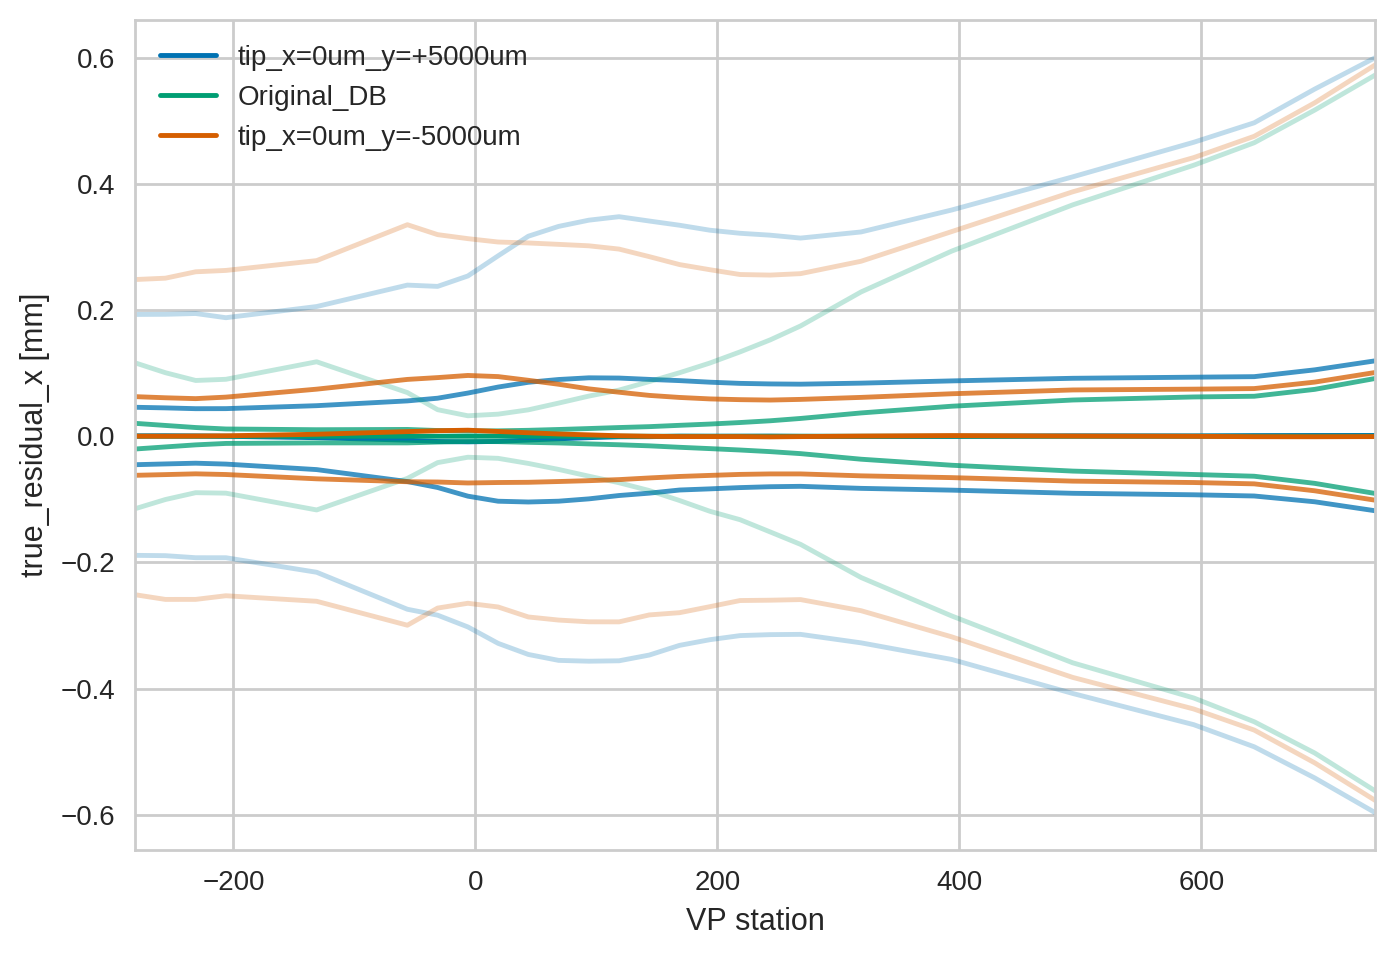

In [14]:
plot_residual('true_residual_x')

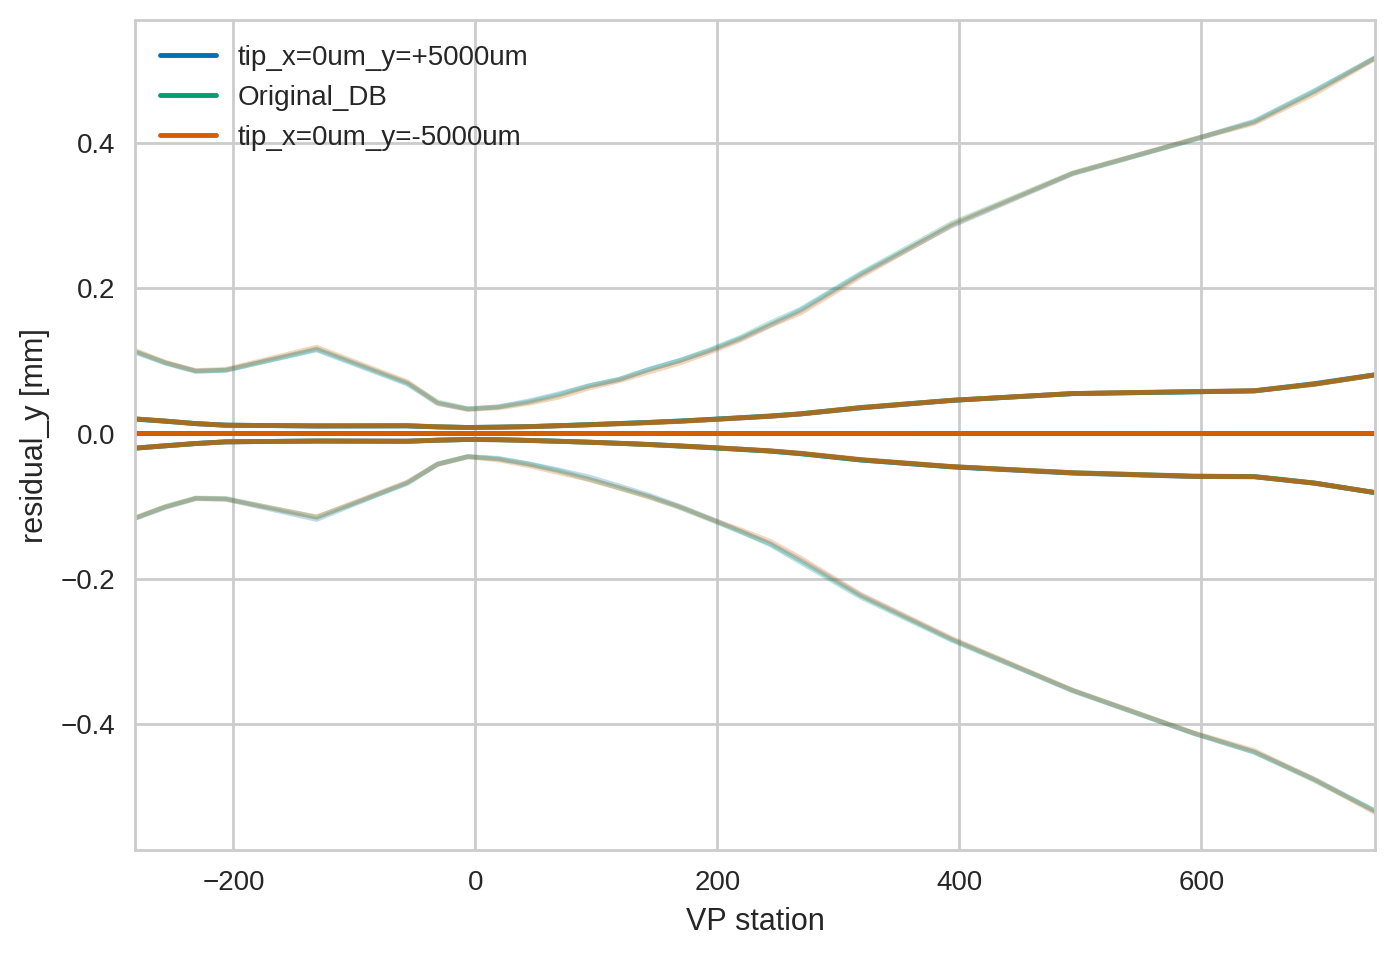

In [15]:
plot_residual('residual_y')

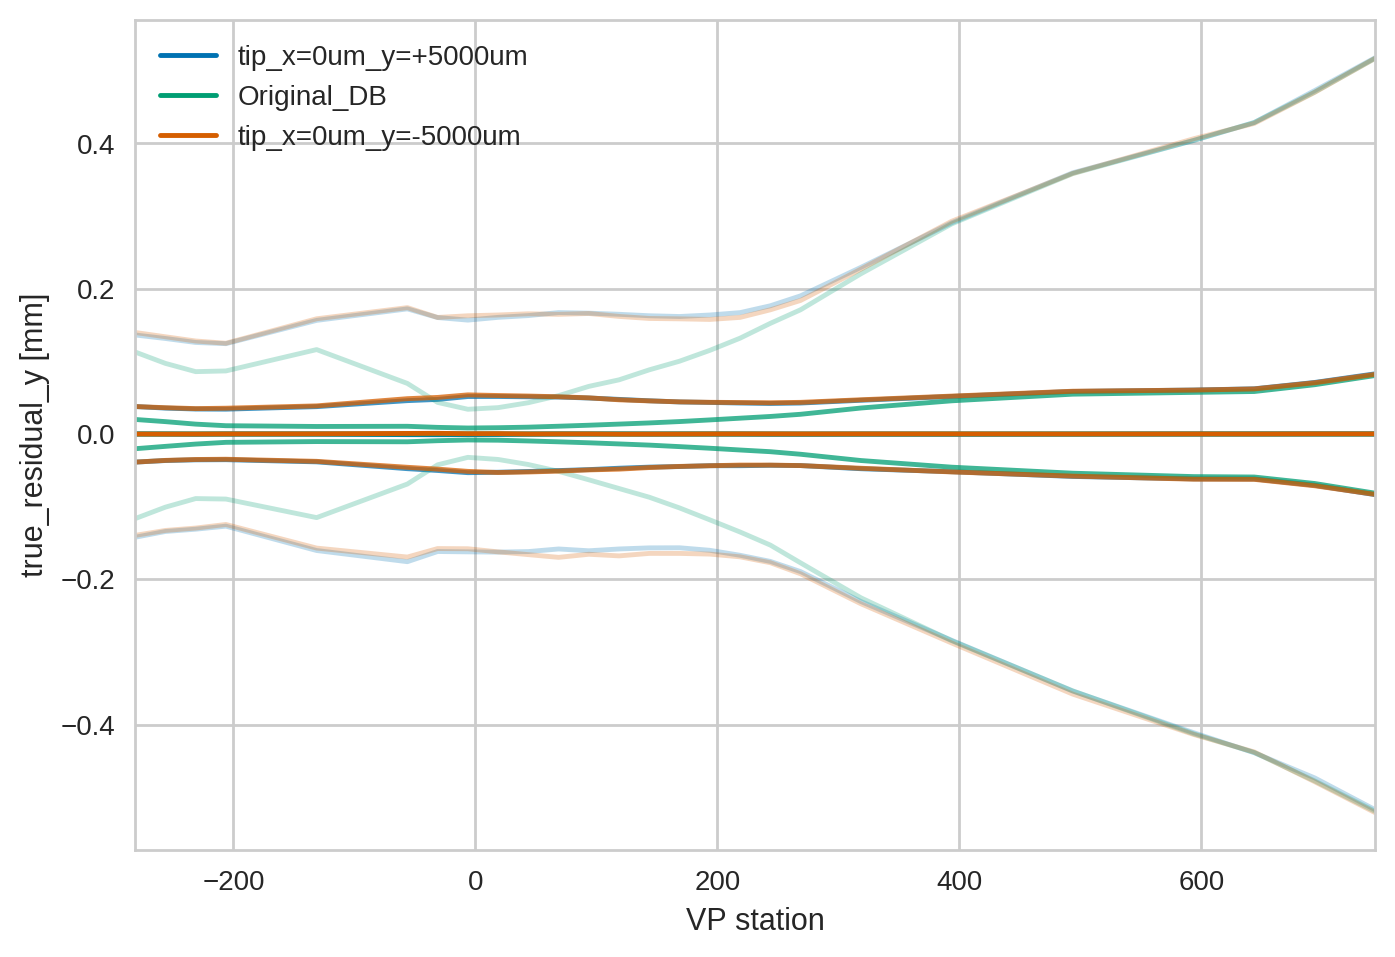

In [16]:
plot_residual('true_residual_y')

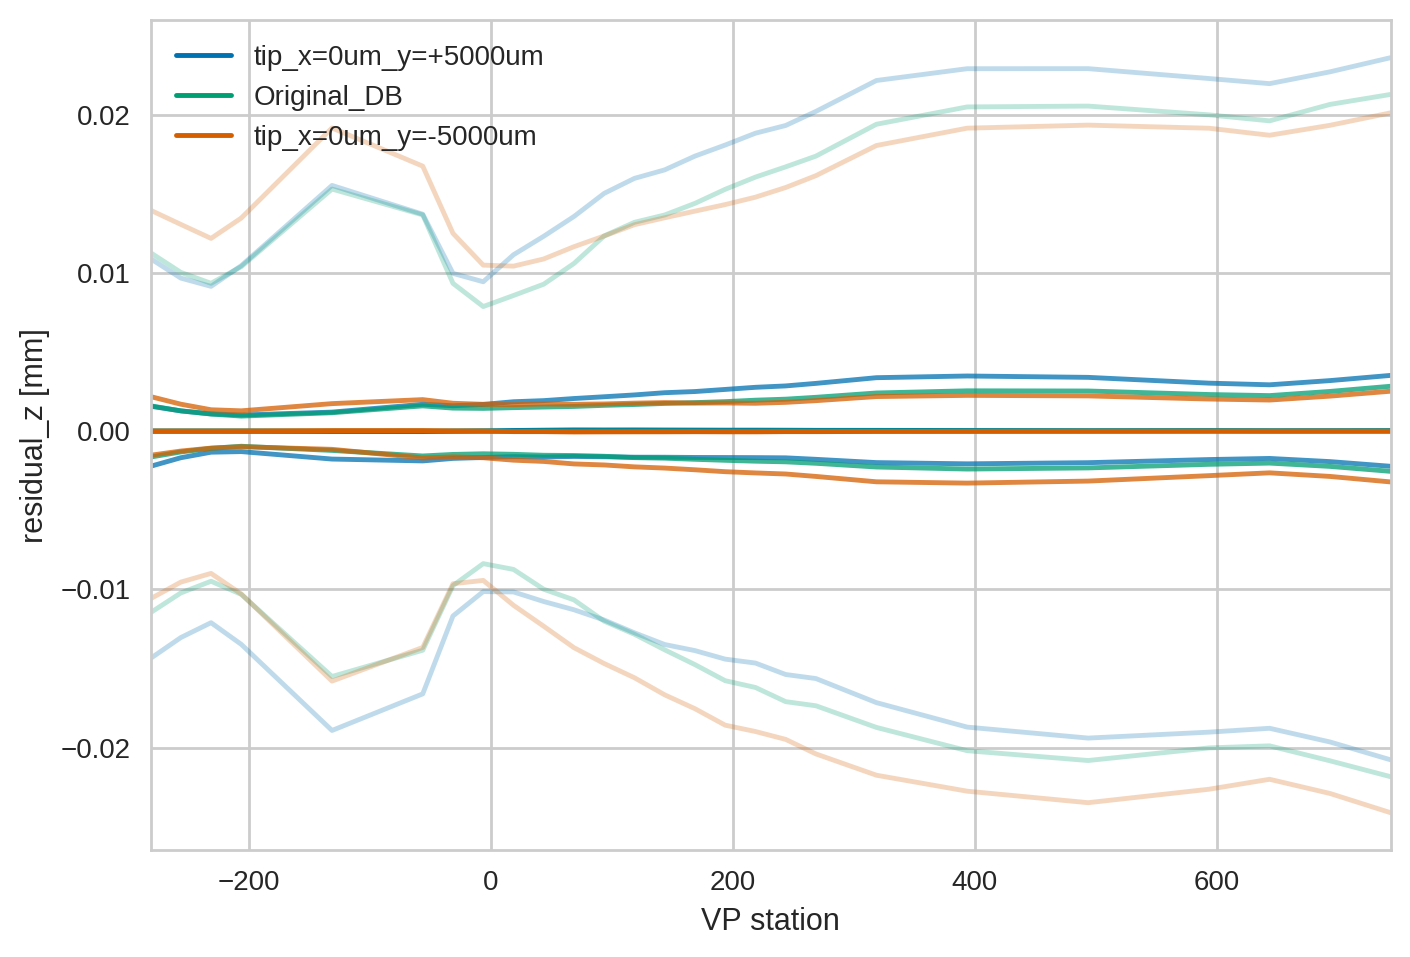

In [17]:
plot_residual('residual_z')

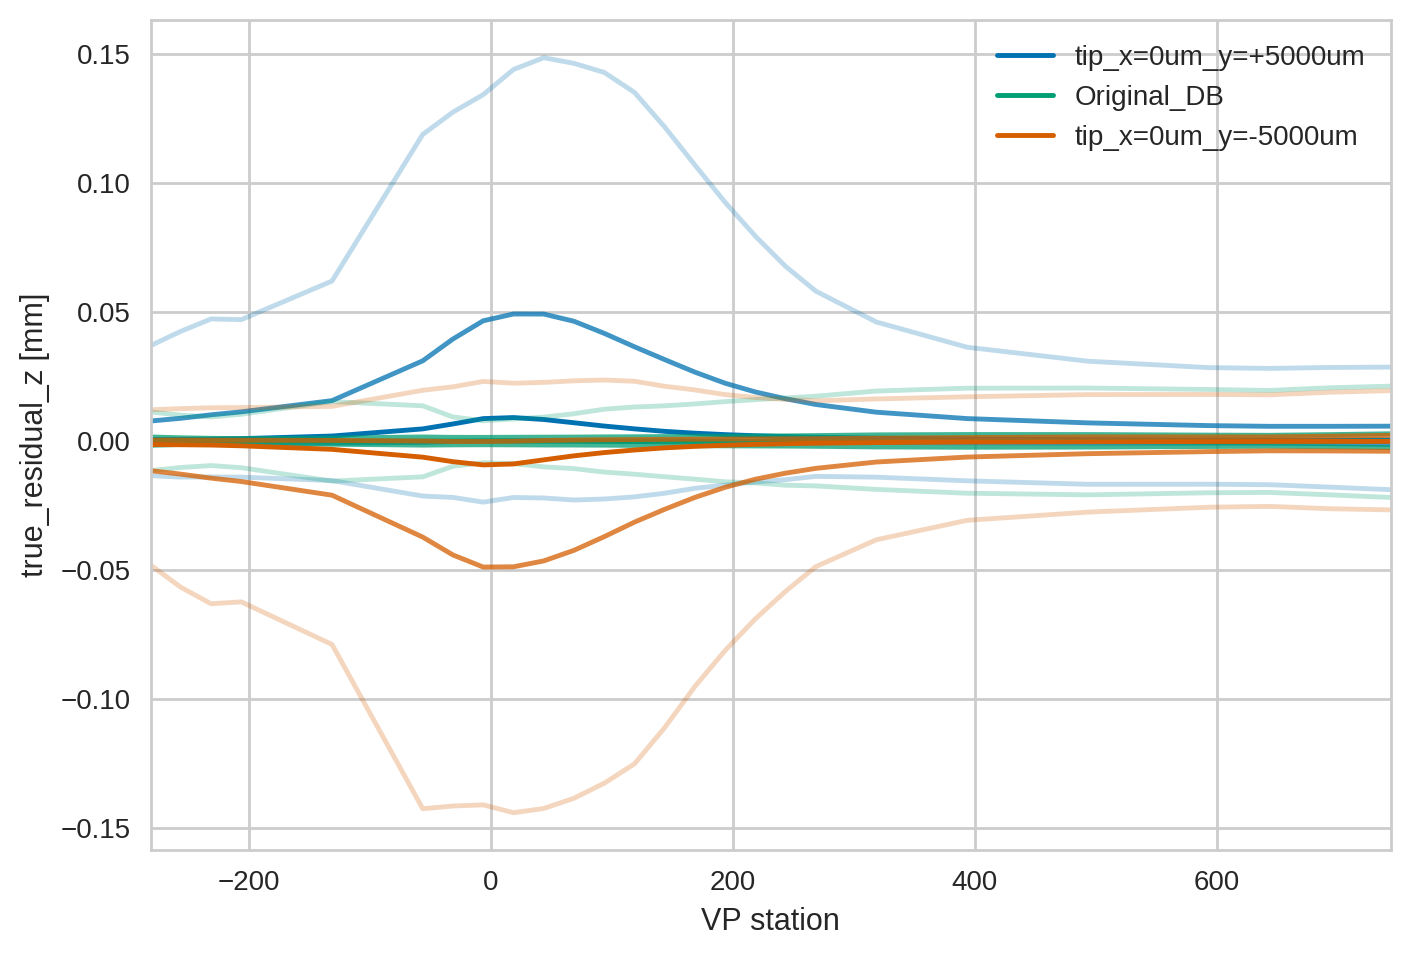

In [18]:
plot_residual('true_residual_z')

## Momentum resolution of all long tracks

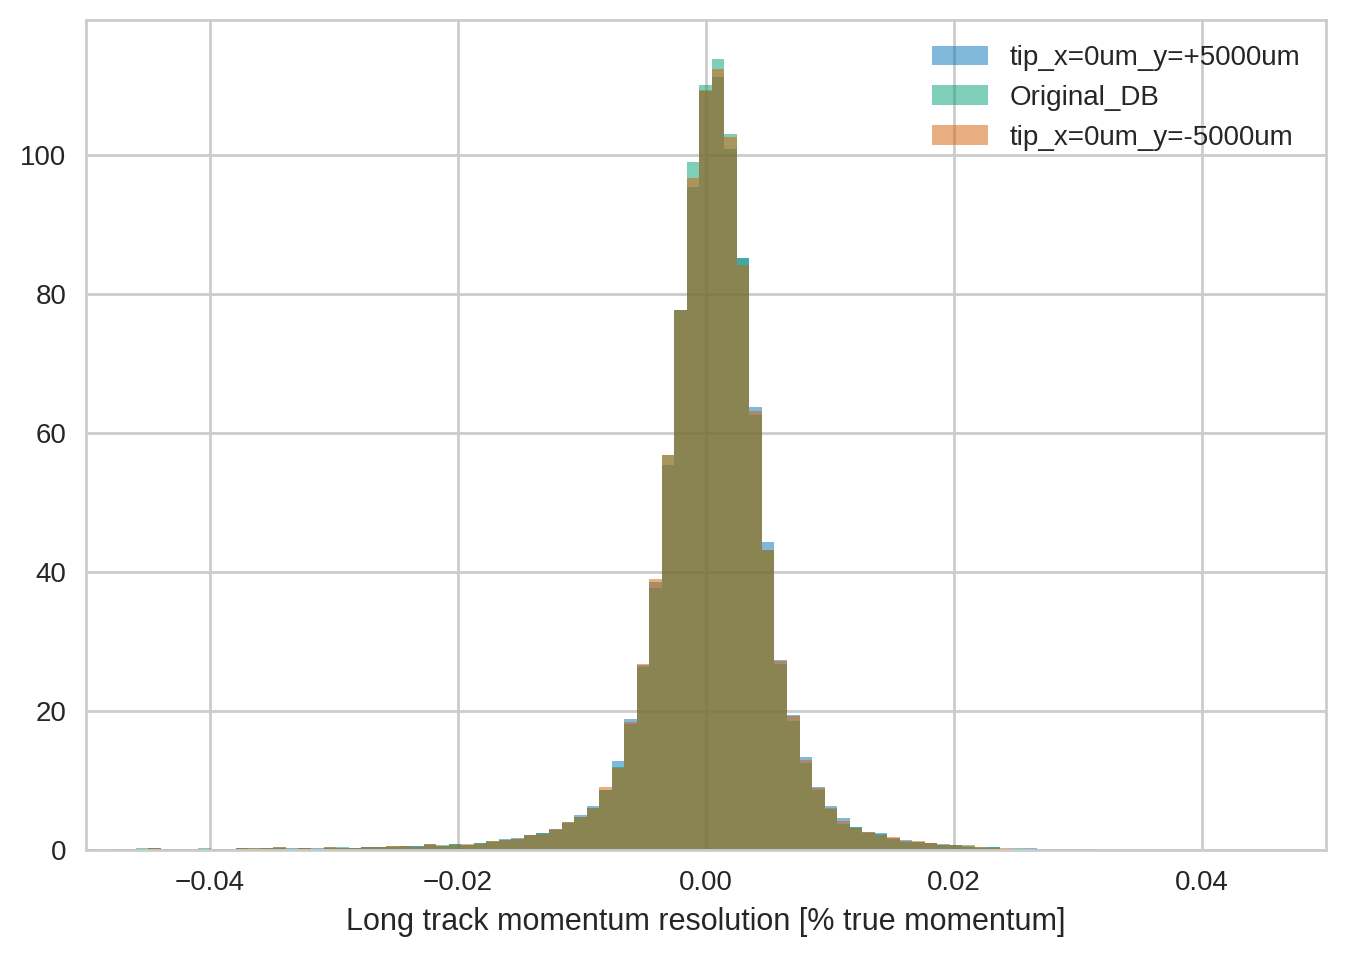

In [19]:
for scenario in scenarios:
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    resolution = long_tracks.eval('(p-true_p)/true_p').dropna()
    resolution.hist(bins=np.linspace(-0.05, 0.05, 100), label=scenario, alpha=0.5, normed=True)
plt.legend(loc='best')
plt.xlim((-0.05, 0.05))
plt.xlabel('Long track momentum resolution [% true momentum]')

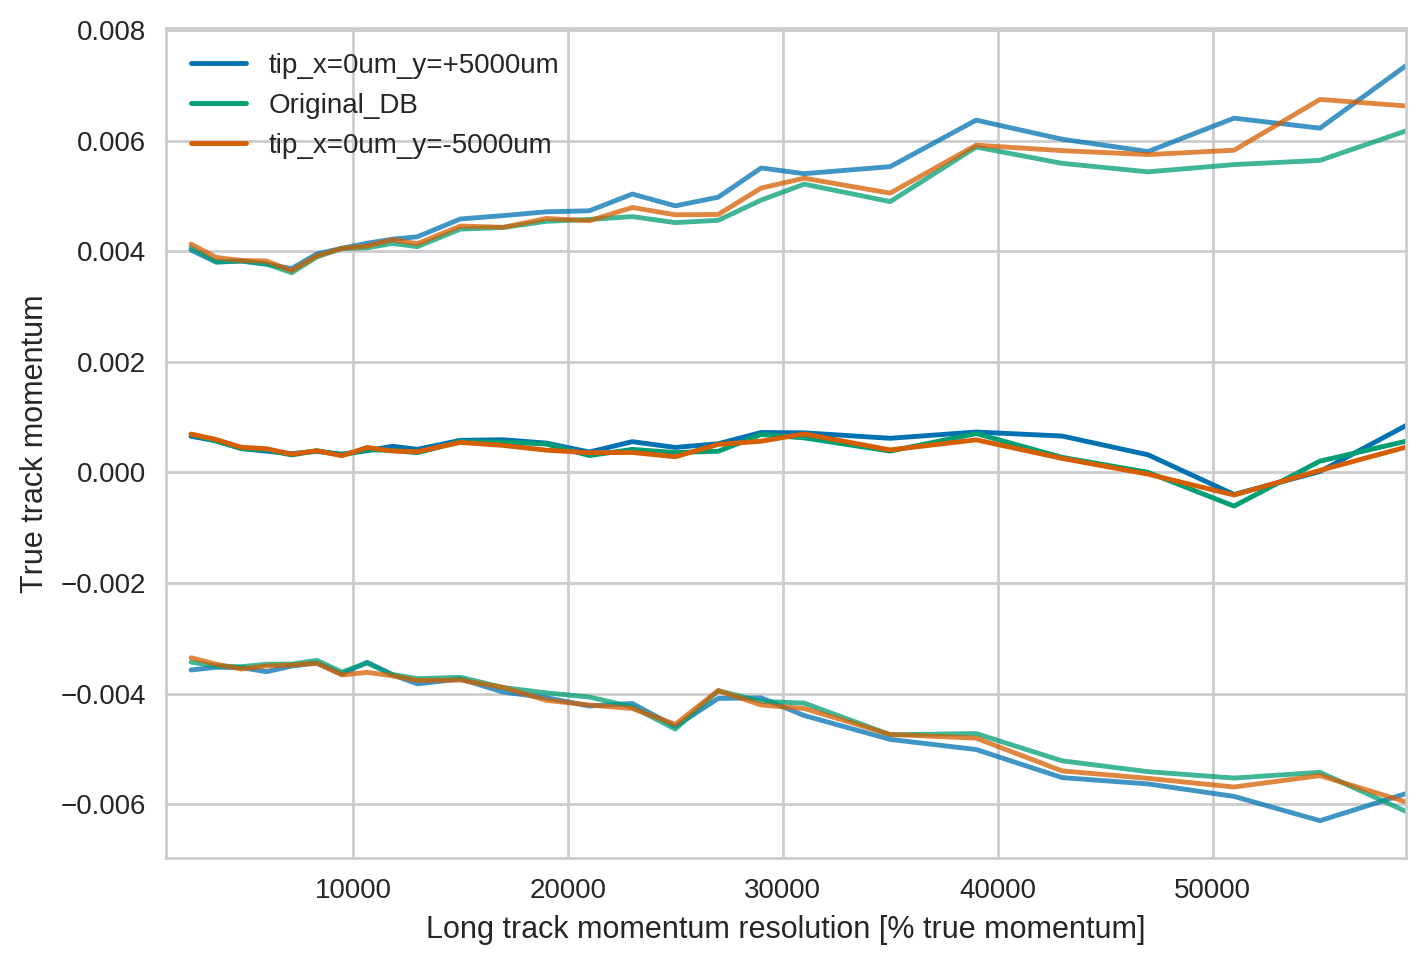

In [20]:
for scenario, colour in zip(scenarios, sns.color_palette(n_colors=len(scenarios))):
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    # Use a variable binning to avoid issues with low stats
    xs = np.concatenate([
        np.linspace(1300, 13000, 11),
        np.arange(15000, 31001, 2000),
        np.arange(35000, 61000, 4000)
    ])
    ys = []
    for p_low, p_high in pairwise(xs):
        resolution = long_tracks.query(f'({p_low} <= true_p) & (true_p < {p_high})')
        resolution = resolution.eval('(p-true_p)/true_p').dropna()
        if len(resolution) < 50:
            print(p_low, scenario, len(resolution))
        ys.append([
            resolution.quantile(0.5+sigma[1]/2),
            resolution.median(),
            resolution.quantile(0.5-sigma[1]/2)
        ])

    for y, alpha in zip(zip(*ys), [0.75, 1, 0.75]):
        plt.plot(xs[:-1]+np.diff(xs), y, c=colour, alpha=alpha, label=(scenario if alpha == 1 else None))

plt.legend(loc='best')
plt.xlim((xs[0], xs[-1]))
plt.xlabel('Long track momentum resolution [% true momentum]')
plt.ylabel('True track momentum')

## $D^0$ vertex fit quality

Here $D^{*+} \rightarrow \left(D^0 \rightarrow K^+ K^- \right) \pi^+$ candidates are reconstructed by:
 - Truth matching tracks (created with NoPIDsParticleMaker) to ensure that all hits on a final state track are assoiated with the same MCParticle
 - The mother of both kaons is then required to be the same MCParticle
 - The mother of the pion must be the same as the mother of the mother of the kaons

The vertex is then fitted using `LoKi::VertexFitter` to build a $D^0$

TODO:
 - Do I need to worry if the mother of the kaon MCParticles is something other than a $D^0$ (so $D^0 \rightarrow X
\rightarrow K^+ K^-)$?
 - Likewise for the $D^{*+}$?

102 (21.9%) events clipped for tip_x=0um_y=+5000um
   0.5σ = 0.137
   1σ   = 0.419
   2σ   = 0.911
39 (8.4%) events clipped for Original_DB
   0.5σ = 0.086
   1σ   = 0.250
   2σ   = 0.520
91 (20.0%) events clipped for tip_x=0um_y=-5000um
   0.5σ = 0.144
   1σ   = 0.426
   2σ   = 1.075


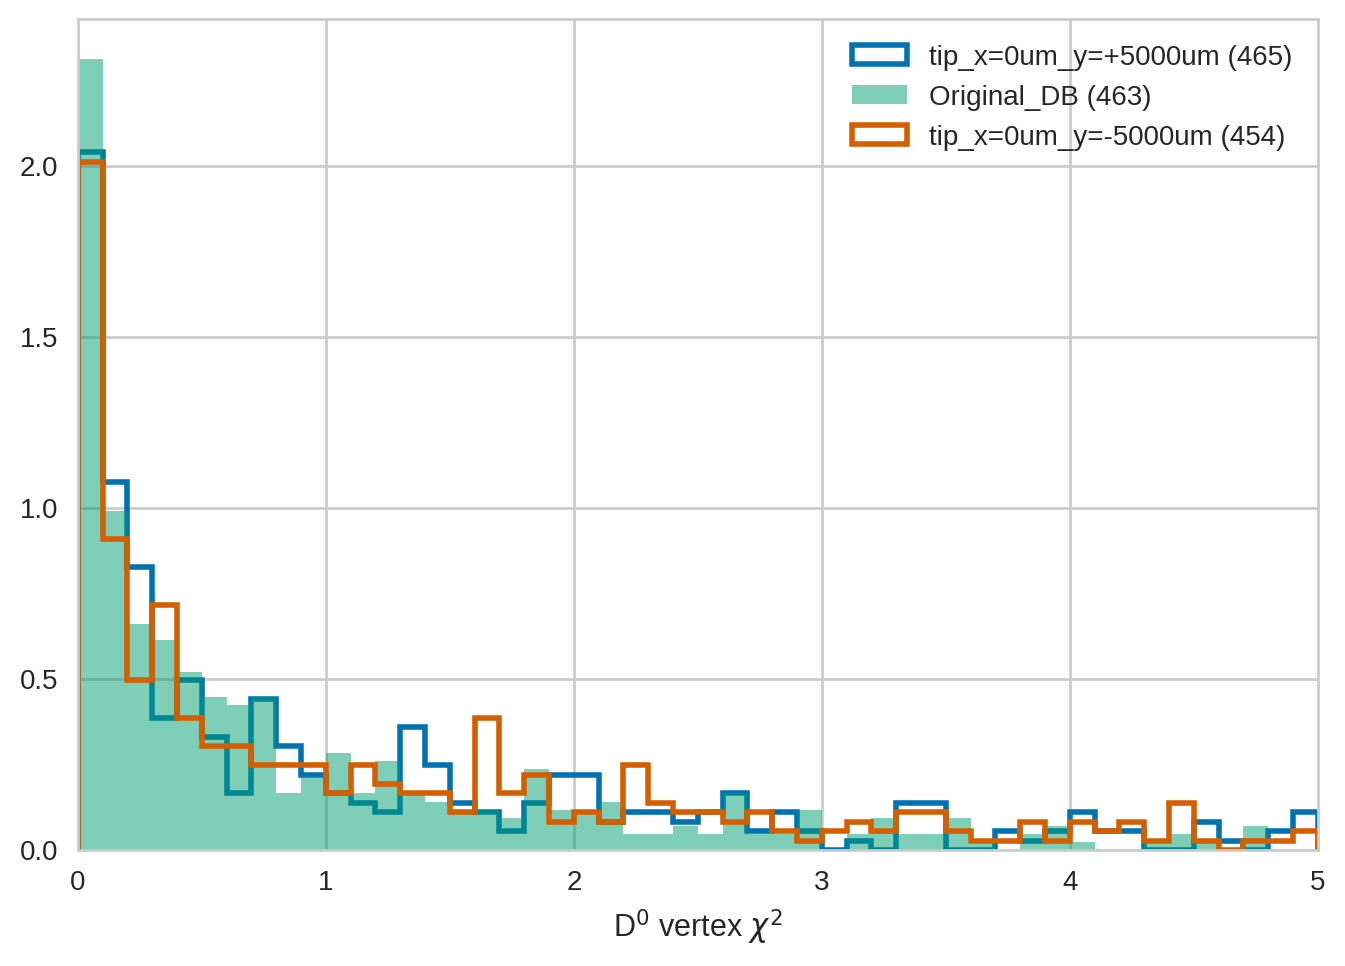

In [21]:
for scenario in scenarios:
    chi2 = particles.query(f'scenario == "{scenario}"').vertex_chi2
    label = f'{scenario} ({len(chi2)})'
    if scenario == 'Original_DB':
        chi2.hist(bins=np.linspace(0, 5, 51), label=label, alpha=0.5, normed=True)
    else:
        chi2.hist(bins=np.linspace(0, 5, 51), label=label, normed=True, histtype='step', lw=2)
    print(f'{sum(chi2 > 5)} ({sum(chi2 > 5)/len(chi2):.1%}) events clipped for {scenario}')
    # Print sigma values for if this was one side of a normal distribution
    print(f'   0.5σ = {chi2.quantile(sigma[0.5]/2):.3f}')
    print(f'   1σ   = {chi2.quantile(sigma[1]/2):.3f}')
    print(f'   2σ   = {chi2.quantile(sigma[2]/2):.3f}')
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('D$^0$ vertex $\chi^2$')

## Flight distance resolution

The flight distance is taken to be the distance between the reconstructed $D^0$ vertex (above) and the true $D^{*+}$ origin vertex. I **do not** consider if the $D^{*+}$ is promptly produced.

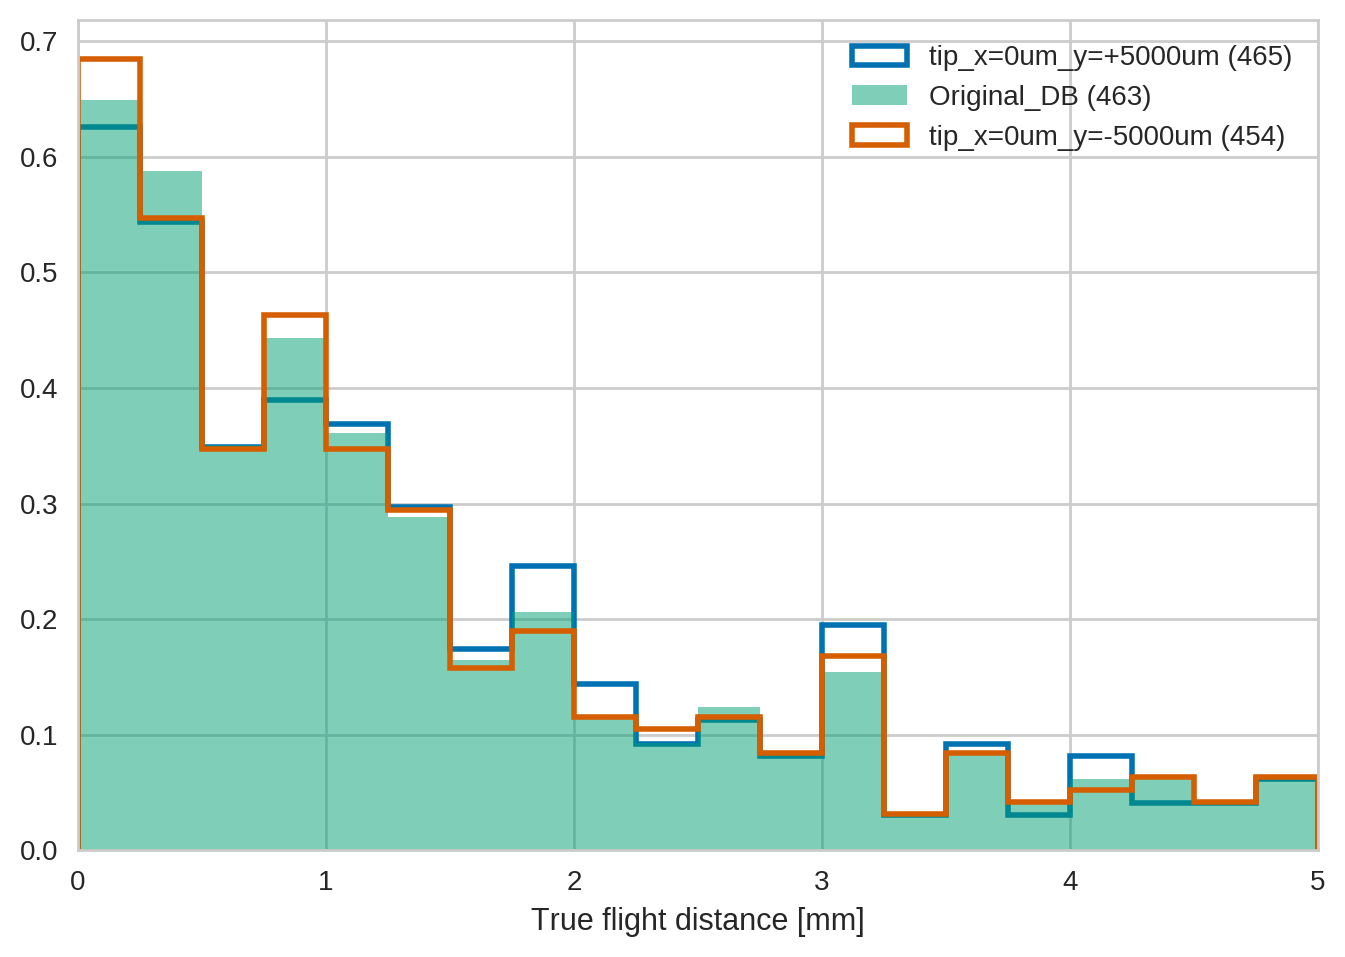

In [22]:
for scenario in scenarios:
    true_fd = particles.query(f'(scenario == "{scenario}")').true_fd
    label = f'{scenario} ({len(true_fd)})'
    if scenario == 'Original_DB':
        true_fd.hist(bins=np.linspace(0, 5, 21), label=label, alpha=0.5, normed=True)
    else:
        true_fd.hist(bins=np.linspace(0, 5, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('True flight distance [mm]')

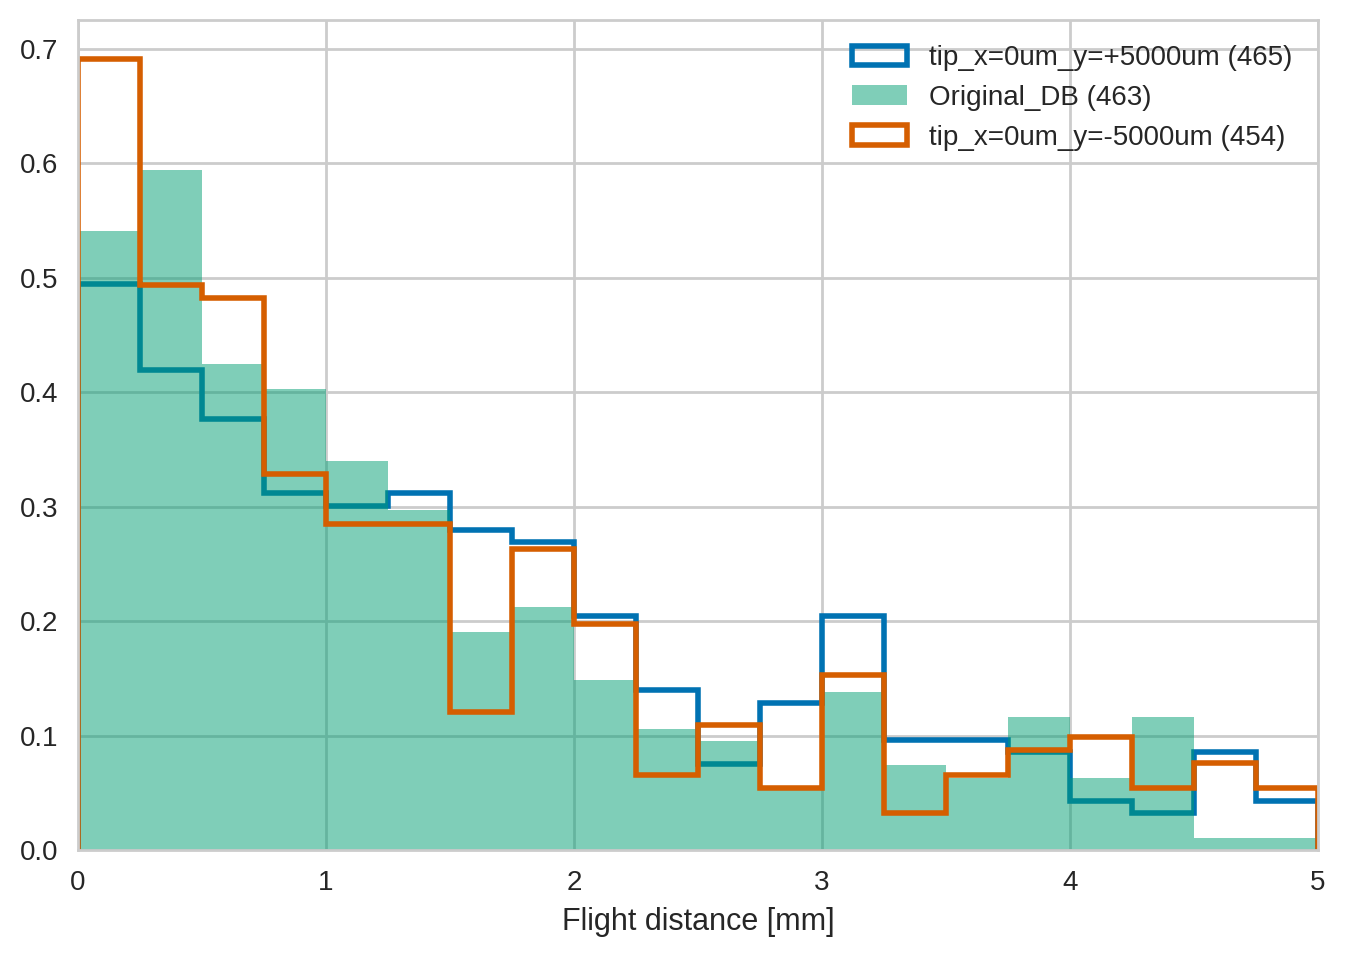

In [23]:
for scenario in scenarios:
    reco_fd = particles.query(f'(scenario == "{scenario}")').fd
    label = f'{scenario} ({len(reco_fd)})'
    if scenario == 'Original_DB':
        reco_fd.hist(bins=np.linspace(0, 5, 21), label=label, alpha=0.5, normed=True)
    else:
        reco_fd.hist(bins=np.linspace(0, 5, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('Flight distance [mm]')

tip_x=0um_y=+5000um 20
  median = -0.123
    0.5σ = 0.522
      1σ = 1.246
Original_DB 20
  median = -0.004
    0.5σ = 0.321
      1σ = 0.852
tip_x=0um_y=-5000um 28
  median = -0.033
    0.5σ = 0.477
      1σ = 1.186


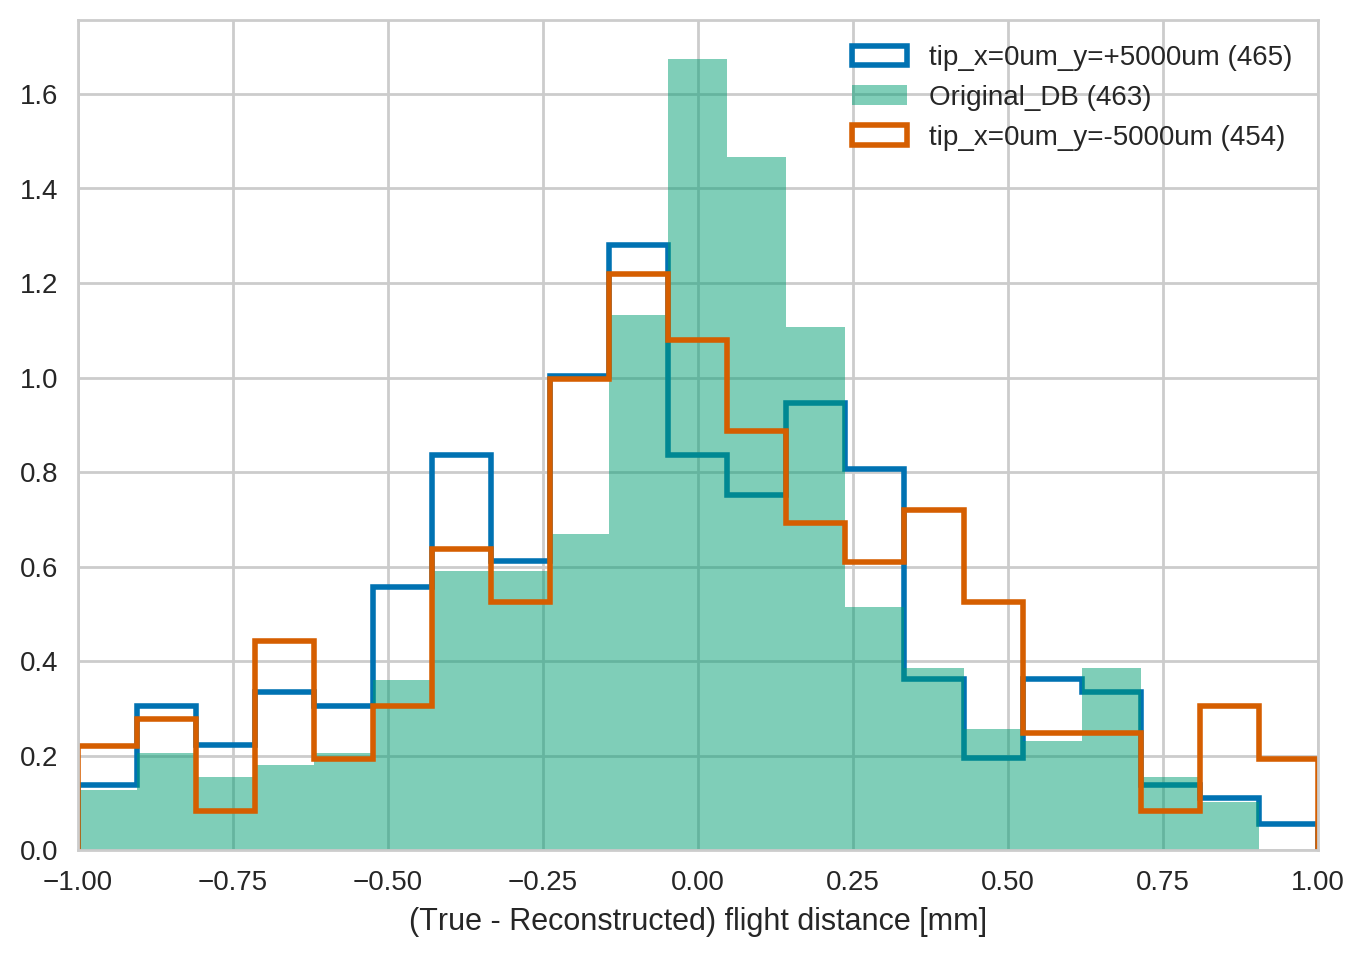

In [24]:
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    reco_fd = _particles.fd
    true_fd = _particles.true_fd
    res = true_fd - reco_fd
    print(scenario, sum(res > 1))
    print(f'  median = {res.median():.3f}')
    print(f'    0.5σ = {res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}')
    print(f'      1σ = {res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}')
    label = f'{scenario} ({len(res)})'
    if scenario == 'Original_DB':
        res.hist(bins=np.linspace(-1, 1, 22), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-1, 1, 22), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((-1, 1))
plt.xlabel('(True - Reconstructed) flight distance [mm]')

## D0 lifetime

Using reconstructed momentum of the $D^0$ in all cases.

$\gamma = \frac{1}{\sqrt{1+\frac{p}{m\left(D^0\right)}^2}}$

$t_{\text{proper}} = \frac{\text{FD}*\gamma}{c}$

In [25]:
particles.eval(f'proper_time = (fd/1000 * D0_gamma) /{speed_of_light}', inplace=True)
particles.eval(f'true_proper_time = (true_fd/1000 * D0_gamma) /{speed_of_light}', inplace=True)

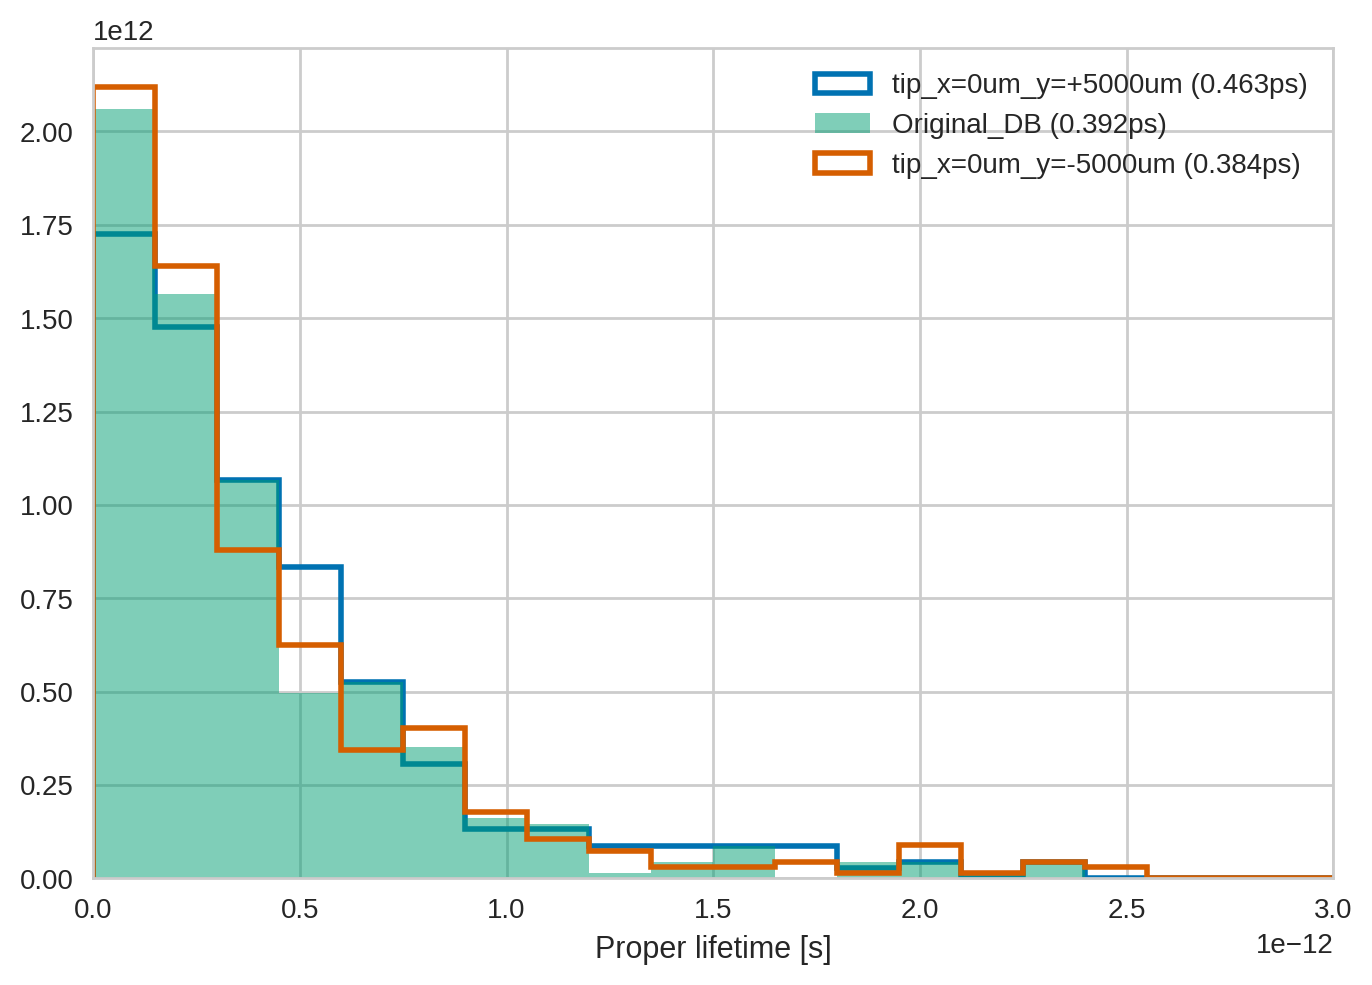

In [26]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').proper_time
    label = f'{scenario} ({lt.quantile(1 - 1/np.exp(1))*1e12:.3f}ps)'
    if scenario == 'Original_DB':
        lt.hist(bins=np.linspace(0, 3e-12, 21), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e-12, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 3e-12))
plt.xlabel('Proper lifetime [s]')

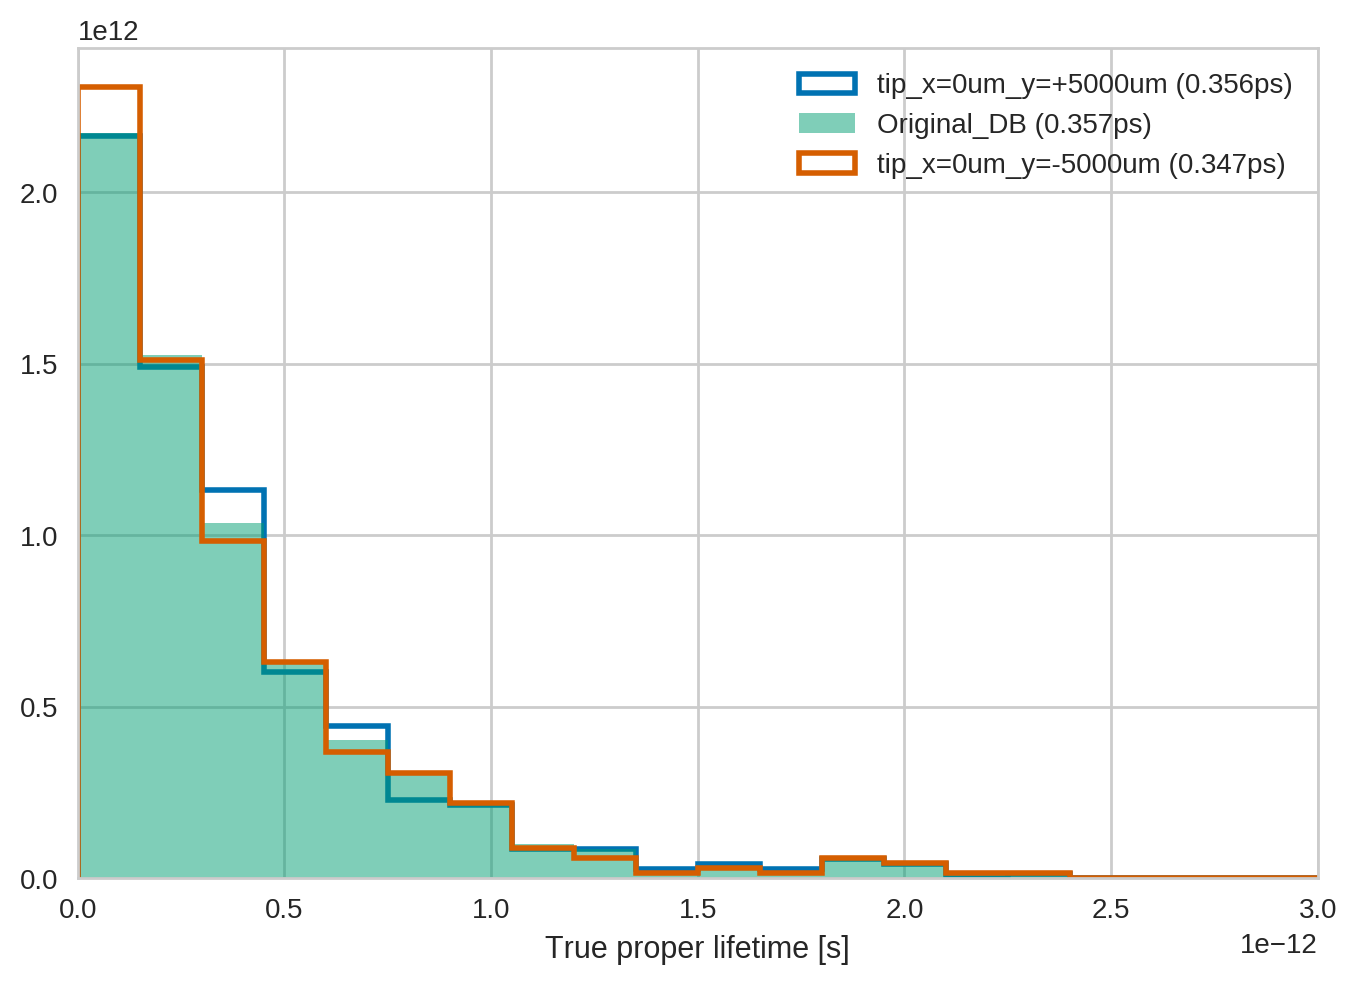

In [27]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').true_proper_time
    label = f'{scenario} ({lt.quantile(1 - 1/np.exp(1))*1e12:.3f}ps)'
    if scenario == 'Original_DB':
        lt.hist(bins=np.linspace(0, 3e-12, 21), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e-12, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 3e-12))
plt.xlabel('True proper lifetime [s]')

tip_x=0um_y=+5000um 0
  median = -0.000
    0.5σ = 0.000
      1σ = 0.000
Original_DB 0
  median = -0.000
    0.5σ = 0.000
      1σ = 0.000
tip_x=0um_y=-5000um 0
  median = -0.000
    0.5σ = 0.000
      1σ = 0.000


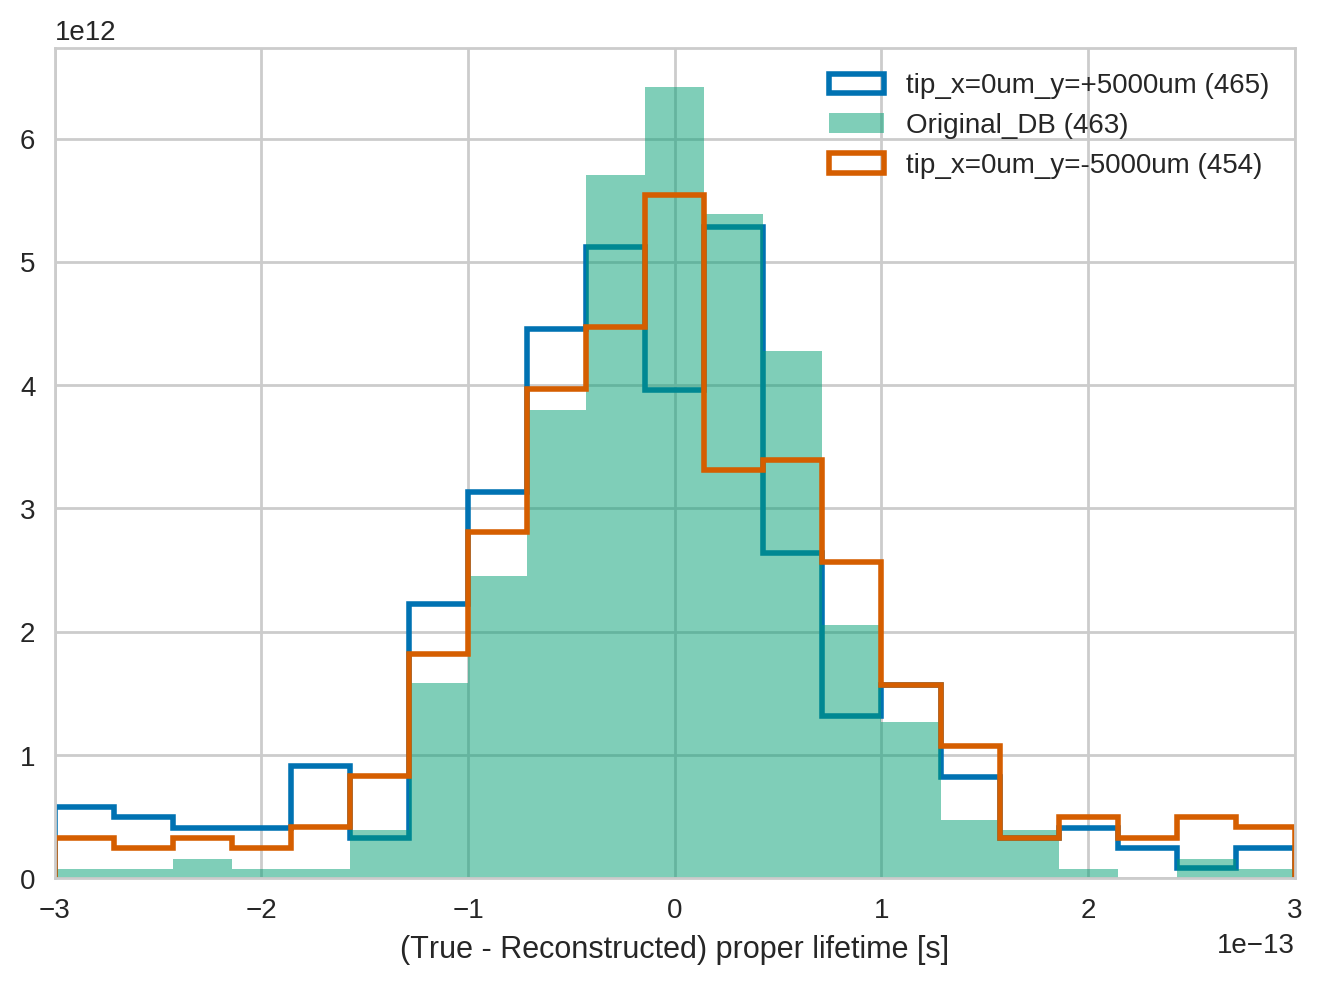

In [28]:
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    res = _particles.true_proper_time - _particles.proper_time
    print(scenario, sum(res > 1))
    print(f'  median = {res.median():.3f}')
    print(f'    0.5σ = {res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}')
    print(f'      1σ = {res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}')
    label = f'{scenario} ({len(res)})'
    if scenario == 'Original_DB':
        res.hist(bins=np.linspace(-3e-13, 3e-13, 22), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-3e-13, 3e-13, 22), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((-3e-13, 3e-13))
plt.xlabel('(True - Reconstructed) proper lifetime [s]')